In [1]:
import torch
import torch.nn as nn
from torch.distributions.categorical import Categorical
import torch.nn.functional as F
import minigrid
import numpy as np
import matplotlib.pyplot as plt
import gym
from tqdm.notebook import tqdm
from minigrid.envs.doorkey import DoorKeyEnv
import pandas as pd
from gym.envs.registration import registry, register
import random
from tqdm import tqdm
from typing_extensions import Self
import matplotlib.pyplot as plt

pygame 2.5.2 (SDL 2.28.3, Python 3.10.14)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
def get_device() -> torch.device:
    """
    Returns the device to use for training.
    """
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [3]:
class Stopwatch:
    def __init__(self, default_time=60):
        """
        A stopwatch to count down a variable
        """

        # check default_time is a non-negative integer
        t = default_time
        assert isinstance(t, int) and t >= 0, f"Default time {t} must be a non-negative integer."

        self.DEFAULT = t
        self.current = 0

    def activate(self, time=None):
        """
        Set the time to time or the maximum time if time is None.

        Args:
            time: int or None
        """

        if time is None:
            self.current = self.DEFAULT
        else:
            # check time is a non-negative integer
            assert isinstance(time, int) and time >= 0, f"Time {time} must be a non-negative integer."
            
            self.current = time

    def count_down(self) -> bool:
        """
        Count down the stopwatch by 1.

        Returns:
            False if the stopwatch has reached 0, True otherwise
        """

        if self.current > 0:
            self.current -= 1
            return True
        else:
            return False
        
    def is_on(self) -> bool:
        """
        Check if the stopwatch is on.

        Returns:
            True if the stopwatch is on, False otherwise
        """

        return self.current > 0

    def deactivate(self):
        self.current = 0

class ContinuousBanditV4:
    """
    Action space: R^1
    Objective: maxiamize the expected reward
    """

    def __init__(self,
                 lb=-float('inf'), 
                 ub=float('inf'), 
                 mean=None, 
                 std=None, 
                 min_std=0,
                 max_std=None,
                 sample_number=20, 
                 alpha=0.2,
                 lr=None,
                 mean_lr=0.03,
                 std_lr=0.03,
                 reward_std_lr=0.1,
                 reincarnation=50,
                 restart_pos=None,
                 restart_lr=0.1,
                 database_capacity=100):
        """
        lb: lower bound of action space
        ub: upper bound of action space
        mean: initial mean of the normal distribution
        std: initial standard deviation of the normal distribution
        min_std: minimum standard deviation allowed
        max_std: maximum standard deviation allowed
        sample_number: the number of actions to sample for each pull
        alpha: the parameter for UCB computation
        lr: the learning rate for mean and std (and reward_std)
        mean_lr: the learning rate for mean
        std_lr: the learning rate for std
        reward_std_lr: the learning rate for reward_std
        reincarnation: the period of reincarnation
        restart_pos: the position to restart the mean
        database_capacity: the capacity of the database to store the historical data
        """

        self.lb = lb
        self.ub = ub
        self.can_use_bounds = (lb != -float('inf') and ub != float('inf'))

        if mean is not None:
            self.mean = mean
        elif self.can_use_bounds:
            self.mean = (self.ub + self.lb) / 2
        elif lb != -float('inf'):
            self.mean = self.lb + 1.0
        elif ub != float('inf'):
            self.mean = self.ub - 1.0
        else:
            self.mean = 0.0
        if std is not None:
            self.std = std
        elif lb != -float('inf') and ub != float('inf'):
            self.std = (self.ub - self.lb) / np.sqrt(12)
        else:
            self.std = 1.0

        if max_std is not None:
            self.max_std = max_std
        elif self.can_use_bounds:
            self.max_std = (self.ub - self.lb) / 2
        else:
            self.max_std = float('inf')
        
        self.min_std = min_std
        self.sample_number = sample_number
        self.alpha = alpha
        # self.epsilon = epsilon
        self.database = self.DataBase(capacity=database_capacity) # to store the historical data
        self.reward_std = 1.0 # to store the std of the reward distribution
        if lr is not None:
            self.mean_lr = lr
            self.std_lr = lr
            self.reward_std_lr = lr
        else:
            self.mean_lr = mean_lr
            self.std_lr = std_lr
            self.reward_std_lr = reward_std_lr

        self.STD_FACTOR = np.sqrt(np.pi / 2)

        self.n = 0 # number of times we pull the arm
        self.previous_a = None # to store the previous action
        self.previous_expected_r = None # to store the previous expected reward

        # these are the memory to draw diagram
        self.col_means = []
        self.col_as = []
        self.col_rs = []
        self.col_std = []

        self.reincarnation = reincarnation
        self.restart_lr = restart_lr
        if restart_pos is not None:
            self.restart_pos = restart_pos
        else:
            self.restart_pos = self.mean


    class DataBase:
        """
        A database to store the historical data of the one-armed bandit problem.
        Data consists of a list of tuples (action, reward)
        """
        
        def __init__(self, capacity: int=100):
            self.data = []
            self.capacity = capacity
            self.bests = [] # store best (a, r, t)'s
            self.protection = Stopwatch(default_time=5) # to protect the bests from being removed too frequently

        def get_length(self) -> int:
            return len(self.data)

        def add_data(self, action: float, reward: float, time_step: int) -> None:
            self.data.append((action, reward, time_step))
            self.bests.append((action, reward, time_step))
            # if exceed capacity, remove the oldest data
            if self.get_length() > self.capacity:
                assert self.get_length() == self.capacity + 1, f'#data = {self.get_length()} > 1 + capacity = {1 + self.capacity}'
                self.data.pop(0)
                # delete the worst reward from bests
                self.bests = sorted(self.bests, key=lambda x: x[1])
                self.bests.pop(0)
            else:
                pass

        def get_data(self) -> list:
            return self.data
        
        def sample_data(self, size: int) -> list:
            return np.random.choice(self.data, size=size)
        
        def fill_bests(self) -> None:
            """
            If bests is not full, fill it with highest current data
            """
            length_bests = len(self.bests)
            assert length_bests <= self.capacity, f'#bests {length_bests} > capacity {self.capacity}.'

            if length_bests < self.capacity:
                num_to_fill = self.capacity - len(self.bests)
                # take num_to_fill bests from data
                best_data = sorted(self.data, key=lambda x: x[1], reverse=True)[:num_to_fill]
                self.bests.extend(best_data)
        
        def compute_std(self, std: float) -> tuple[int, float]:
            """
            Compute std of rewards according to the bests

            Args:
                std: the std of the policy

            Returns:
                mode: 0 for normal
                        1 for need adjustment
                        2 for too small database
                std: the std of the reward distribution
                        if mode = 1, then is the target std to adjust self.std above
            """
            def helper_radius(A: list[float], b: float, are_sort=True) -> float:
                """
                Compute min(abs(a - b)) for a in A

                Args:
                    A: a list of floats
                    b: a float
                    are_sort: if True, A is sorted in ascending order
                
                Returns:
                    min(abs(a - b)) for a in A
                """
                if not are_sort:
                    A = sorted(A)

                low = 0
                high = len(A) - 1
                if A[low] > b:
                    return A[low] - b  
                elif A[high] < b:
                    return b - A[high]
                
                while low < high - 1:
                    mid = (low + high) // 2
                    if A[mid] < b:
                        low = mid
                    else:
                        high = mid

                radius = min(A[high] - b, b - A[low])
                assert radius >= 0, f'radius = {radius} < 0'
                
                return radius

            def helper_min_radius(A: list[float], B: list[float], num_to_fill: int) -> float:
                """
                Compute the minimum radius r such that num_to_fill elements of data from B is within r from A
                """

                # sort A
                A = sorted(A)
                radius_list = []

                for b in B:
                    radius = helper_radius(A, b)
                    radius_list.append(radius)

                # then select the num_to_fill smallest of radius_list
                radius_list = sorted(radius_list)

                return radius_list[num_to_fill - 1]

            if len(self.bests) <= 3:
                return 2, 0.0
            elif self.get_length() < self.capacity:
                return 0, np.std([reward for _, reward, _ in self.bests])
            
            good_data = []

            # take 20 elites from self.bests
            elites = sorted(self.bests, key=lambda x: x[1], reverse=True)[:20]
            elite_as = [a for a, _, _ in elites]
            elite_as = sorted(elite_as)

            for action, reward, t in self.get_data():
                radius = helper_radius(elite_as, action)
                if radius < 2 * std:
                    good_data.append((action, reward, t))

            if len(good_data) >= 10:
                self.protection.count_down()
                return 0, np.std([reward for _, reward, _ in good_data])
            else:
                data_as = [a for a, _, _ in self.get_data()]
                target_std = helper_min_radius(elite_as, data_as, self.get_length() // 2)
                assert target_std >= 2 * std, f'elite_as: {elite_as}\n data_as: {data_as}\n std: {std}\n target_std: {target_std}\n good_data: {good_data}'

                # remove the earliest data in elites from bests
                if not self.protection.is_on():
                    elites = sorted(elites, key=lambda x: x[2])
                    earliest_data = elites[0]
                    self.bests.remove(earliest_data)
                    self.fill_bests()
                
                self.protection.activate()

                return 1, target_std


    def get_mean(self) -> float:
        return self.mean
    
    def get_std(self) -> float:
        return self.std

    def get_sample_number(self) -> int:
        return self.sample_number
    
    def set_sample_number(self, sample_number: int) -> None:
        self.sample_number = sample_number

    def sample_actions(self, size: int) -> np.ndarray[float]:
        """
        sample action according to mean and variance
        args:
            size: the number of actions to sample
        returns:
            actions
        """
        a = np.random.normal(self.mean, self.std, size=size)
        a = np.clip(a, self.lb, self.ub)
        return a
    
    def get_neighbors(self, x: float, k: int) -> list[tuple[float, float, float]]:
        """
        get k nearest neighbors of x in the database
        args:
            x: the query point
            k: the number of neighbors to return
        returns:
            list of length k, each element is a tuple
                    (action, reward, distance)
        """
        distances = [np.abs(x - action) for action, _, _ in self.database.get_data()]
        # if database is too small, return all data
        length_of_database = self.database.get_length()
        if length_of_database < k:
            return [(self.database.get_data()[i][0], self.database.get_data()[i][1], distances[i]) for i in range(length_of_database)]
        
        indices = np.argsort(distances)[:k]
        return [(self.database.get_data()[i][0], self.database.get_data()[i][1], distances[i]) for i in indices]

    def get_ucb(self, a: float) -> float:
        """
        get the upper confidence bound of action a
        args:
            a: the action
        returns:
            the upper confidence bound
        """
        length_of_database = len(self.database.data)
        if length_of_database == 0:
            return float('inf')
        
        neighbors = self.get_neighbors(a, k=20)
        rewards = [reward for _, reward, _ in neighbors]
        value = np.mean(rewards)
        self.previous_expected_r = value
        # normalize value
        value /= self.reward_std + 1e-8
        # unexplored = sum(np.log(distance + 1e-8) for _, _, distance in neighbors) / len(neighbors)
        unexplored = -sum(np.sqrt(self.std / (distance + 1e-8)) for _, _, distance in neighbors) / len(neighbors)
        return value + self.alpha * unexplored

    def pull(self) -> float:
        """
        returns:
            best_action
        """
        # sample sample_number actions
        actions = self.sample_actions(self.get_sample_number())
        # get the action with the highest upper confidence bound
        best_action = max(actions, key=self.get_ucb)

        self.get_ucb(best_action) # just to update self.previous_expected_r

        self.previous_a = best_action

        self.n += 1

        return best_action
    
    def update_with_a(self, a: float, reward: float) -> None:
        """
        use (a, reward) to update the mean, std, and database

        args:
            a: the action
            reward: the reward
        """
        def update_mean(target: float, deviation:float) -> None:
            """
            Args:
                target: the target mean
                deviation: how much std(rewards) was current r shifted from expected r
            """
            def helper_sigmoid(x: float) -> float:
                return 1 / (1 + np.exp(-x))
            def helper_sigmoid_inverse(y: float) -> float:
                return np.log(y / (1 - y))
            
            base = helper_sigmoid_inverse(self.mean_lr)
            base = base + deviation
            tau = helper_sigmoid(base)
            tau = np.clip(tau, self.mean_lr / 3, float('inf'))

            self.mean = (1 - tau) * self.mean + tau * target
        
        def update_std(target: float) -> None:
            self.std = (1 - self.std_lr) * self.std + self.std_lr * target

        def update_reward_std(target: float) -> None:
            self.reward_std = (1 - self.reward_std_lr) * self.reward_std + self.reward_std_lr * target

        # first of all, append data into collections
        self.col_means.append(self.mean)
        self.col_as.append(a)
        self.col_rs.append(reward)
        self.col_std.append(self.std)

        # add data to database
        self.database.add_data(a, reward, self.n)

        # update mean
        current_mean = self.mean
        if self.previous_expected_r is not None:
            deviation = (reward - self.previous_expected_r) / (self.reward_std + 1e-8)
        else:
            deviation = 0.0
        update_mean(a, deviation)
        
        # update reward_std
        mode, std = self.database.compute_std(self.std)
        if mode == 0:
            update_reward_std(std)
        elif mode == 1:
            # increase std
            #print('adjusted')
            update_std(std)
        elif mode == 2:
            pass
        # update mean and std
        update_std(self.STD_FACTOR * np.abs(a - current_mean))
        self.std = np.clip(self.std, self.min_std, self.max_std)

        # do reincarnation
        if self.n % self.reincarnation == 0 and self.n >= 2 * self.reincarnation:
            average_r_before = np.mean(self.col_rs[-2 * self.reincarnation: -self.reincarnation])
            average_r_after = np.mean(self.col_rs[-self.reincarnation:])
            if average_r_after <= average_r_before:
                self.restart()
    
    def update(self, reward: float) -> None:
        """
        use (a, reward) to update the mean, std, and database
        a = self.previous_a

        args:
            reward: the reward
        """
        self.update_with_a(self.previous_a, reward)

    def restart(self) -> None:
        """
        restart the mean to restart_pos
        """
        shift = self.mean - self.restart_pos
        self.mean = self.restart_pos
        # soft update restart_pos
        self.restart_pos += self.restart_lr * shift

    def draw(self, low=0, high=None, draw_mean=True, draw_a=True, draw_r=False, draw_std=False) -> None:
        """
        draw the diagram of the one-armed bandit problem
        """
        length = len(self.col_means)

        if high is None:
            high = length

        plt.figure()
        x_axis = range(length)
        if draw_mean:
            plt.plot(x_axis[low:high], self.col_means[low:high], label='mean')
        if draw_a:
            plt.plot(x_axis[low:high], self.col_as[low:high], label='a')
        if draw_std:
            plt.plot(x_axis[low:high], self.col_std[low:high], label='std')
        
        plt.legend()
        plt.show()

        if draw_r:
            plt.figure()
            plt.plot(x_axis[low:high], self.col_rs[low:high], label='r')


In [4]:
# Function from https://github.com/ikostrikov/pytorch-a2c-ppo-acktr/blob/master/model.py
def init_params(m):
    """
    Initialize parameters of the network.
    m: torch.nn.Module
    """
    classname = m.__class__.__name__
    if classname.find("Linear") != -1:
        m.weight.data.normal_(0, 1)
        m.weight.data *= 1 / torch.sqrt(m.weight.data.pow(2).sum(1, keepdim=True))
        if m.bias is not None:
            m.bias.data.fill_(0)

def preprocess_obss(obss, device=None):
    """
    Convert observation into Torch.Tensor

    Parameters
    ----
    obss: dictionary or np.ndarray
    device: target device of torch.Tensor ('cpu', 'cuda')

    Return
    ----
    Torch Tensor
    """
    if isinstance(obss, dict):
        images = np.array([obss["image"]])
    else:
        images = np.array([o["image"] for o in obss])

    return torch.tensor(images, device=device, dtype=torch.float)

class DoorKeyEnv5x5(DoorKeyEnv):
    def __init__(self):
        self.render_mode = "rgb_array"
        super().__init__(size=5)

    def _reward(self):
        """
        Compute the reward to be given upon success
        """
        return 1
    
class DoorKeyEnv6x6(DoorKeyEnv):
    def __init__(self):
        self.render_mode = "rgb_array"
        super().__init__(size=6)

    def _reward(self):
        """
        Compute the reward to be given upon success
        """
        return 1
    
class DoorKeyEnv8x8(DoorKeyEnv):
    def __init__(self):
        self.render_mode = "rgb_array"
        super().__init__(size=8)

    def _reward(self):
        """
        Compute the reward to be given upon success
        """
        return 1
    

In [5]:
class Config:
    """
    Stores algorithmic hyperparameters.
    """
    def __init__(self,
                score_threshold=0.93,
                discount=0.995,
                lr=1e-3,
                max_grad_norm=0.5,
                log_interval=10,
                max_episodes=2000,
                gae_lambda=0.95,
                use_critic=False,
                clip_ratio=0.2,
                target_kl=0.01,
                train_ac_iters=5,
                use_discounted_reward=False,
                entropy_coef=0.01,
                use_gae=True,
                my_var=0):

        self.score_threshold = score_threshold # criterion for early stopping. If the rolling average reward (over the last 100 episodes) is greater than it, it ends.
        self.discount = discount # discount factor
        self.lr = lr # learning rate
        self.max_grad_norm = max_grad_norm # the maximum gradient norm (https://pytorch.org/docs/stable/generated/torch.nn.utils.clip_grad_norm_.html)
        self.log_interval = log_interval # logging interval
        self.max_episodes = max_episodes # the maximum number of episodes.
        self.use_critic = use_critic # whether to use critic or not.
        self.clip_ratio = clip_ratio # clip_ratio of PPO.
        self.target_kl = target_kl # target KL divergence for early stoping train_ac_iters for PPO
        self.train_ac_iters = train_ac_iters # how many time to train ac_model using current computed old_logps
        self.gae_lambda=gae_lambda # lambda in Generalized Advantage Estimation (GAE)
        self.use_discounted_reward=use_discounted_reward # whether use discounted reward or not.
        self.entropy_coef = entropy_coef # entropy coefficient for PPO
        self.use_gae = use_gae # whether to use GAE or not.
        self.my_var = my_var # a variable for testing purposes.
        

In [6]:
def set_random_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

class ACModel(nn.Module):
    def __init__(self, num_actions, use_critic=False):
        """
        Represents an Actor Crictic model that takes a 2d, multi-channeled
        image as input.

        Parameters
        ----
        num_actions : int

                      The action space of the environment.
                      The action space for DoorKey5x5 is 7-dimensional:
                      0: turn left,
                      1: turn right,
                      2: forward,
                      3: pickup an object,
                      4: drop an object,
                      5: activate an object,
                      6: done completing task

        use_critics : bool

                      Critic network will be used in forward pass if flag is set
                      to true.
        """
        super().__init__()
        self.use_critic = use_critic

        # Define actor's model
        self.image_conv_actor = nn.Sequential(
            nn.Conv2d(3, 16, (2, 2)),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),
            nn.Conv2d(16, 32, (2, 2)),
            nn.ReLU(),
            nn.Conv2d(32, 64, (2, 2)),
            nn.ReLU()
        )
        self.actor = nn.Sequential(
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, num_actions)
        )

        # Define critic's model
        if self.use_critic:
            self.image_conv_critic = nn.Sequential(
                nn.Conv2d(3, 16, (2, 2)),
                nn.ReLU(),
                nn.MaxPool2d((2, 2)),
                nn.Conv2d(16, 32, (2, 2)),
                nn.ReLU(),
                nn.Conv2d(32, 64, (2, 2)),
                nn.ReLU()
            )
            self.critic = nn.Sequential(
                nn.Linear(64, 64),
                nn.Tanh(),
                nn.Linear(64, 1)
            )

        # Initialize parameters correctly
        self.apply(init_params)

    def forward(self, obs):
        """
        Performs a forward pass through the actor-critic network

        Parameters
        ----
        obs : int tensor. Shape [Batch size, ImWidth, ImHeight, Channels]

              input to the network.
        ----

        returns:

        dist : torch.distribution
            The distribution of actions from policy. A Categorical distribution
            for discreet action spaces.
        value : torch.Tensor (Batch size, 1)
            value output by critic network
        """
        conv_in = obs.transpose(1, 3).transpose(2, 3) # reshape into [b, c, h, w]

        dist, value = None, None

        x = self.image_conv_actor(conv_in)
        embedding = x.reshape(x.shape[0], -1)

        x = self.actor(embedding)
        dist = Categorical(logits=F.log_softmax(x, dim=1))

        if self.use_critic:
            y = self.image_conv_critic(conv_in)
            embedding = y.reshape(y.shape[0], -1)

            value = self.critic(embedding).squeeze(1)
        else:
            value = torch.zeros((x.shape[0], 1), device=x.device)
        
        return dist, value

def compute_discounted_return(rewards, discount, device=None):
    """
		rewards: reward obtained at timestep.  Shape: (T,)
		discount: discount factor. float

    ----
    returns: sum of discounted rewards. Shape: (T,)
	"""
    if device is None:
        device = get_device()
        
    returns = torch.zeros(*rewards.shape, device=device)

    R = 0
    for t in reversed(range((rewards.shape[0]))):
        R = rewards[t] + discount * R
        returns[t] = R
    return returns

def compute_advantage_gae(values, rewards, T, gae_lambda, discount):
    """
    Compute Adavantage wiht GAE. See Section 4.4.2 in the lecture notes.

    values: value at each timestep (T,)
    rewards: reward obtained at each timestep.  Shape: (T,)
    T: the number of frames, float
    gae_lambda: hyperparameter, float
    discount: discount factor, float

    -----

    returns:

    advantages : tensor.float. Shape [T,]

                 gae advantage term for timesteps 0 to T

    """
    advantages = torch.zeros_like(values)
    for i in reversed(range(T)):
        next_value = values[i+1]
        next_advantage = advantages[i+1]

        delta = rewards[i] + discount * next_value  - values[i]
        advantages[i] = delta + discount * gae_lambda * next_advantage
    return advantages[:T]


In [50]:
class Machine:
    def __init__(self, coef, label, num_actions=7, args:Config=None):
        """
        A Machine object consists of a ACModel, its hyperparameters, and its rewards.

        Args:
            coef: Entropy coefficient.
            label: the label of the machine.
            num_actions
            args: Model hyperparameters
        """
        if args is None:
            self.args = Config()
        else:
            self.args = args
        self.model = ACModel(num_actions, use_critic=self.args.use_critic).to(get_device())
        self.optim = torch.optim.Adam(self.model.parameters(), lr=self.args.lr)
        self.coef = coef
        self.rewards = []
        self.label = label

    def reset_rs(self) -> None:
        self.rewards = []

    def copy_model(self, model: ACModel) -> None:
        """
        Copy state dict from 'model'. Reset rs.
        """
        state_dict = model.state_dict()
        for key, v in state_dict.items():
            self.model.state_dict()[key].copy_(v)

        self.reset_rs()

    def copy_machine(self, other: Self) -> None:
        """
        Copy state dict from 'other'. Reset rs.
        """
        self.copy_model(other.model)

    def add_r(self, r: float) -> None:
        self.rewards.append(r)

    def avg_r(self) -> float:
        assert len(self.rewards) > 0, 'No rewards yet'
        return sum(self.rewards) / len(self.rewards)
    
    def collect_experiences(self, env:gym.Env):
        """
        Collects rollouts and computes advantages.

        Returns
        -------
        exps : dict
            Contains actions, rewards, advantages etc as attributes.
            Each attribute, e.g. `exps['reward']` has a shape
            (self.num_frames, ...).
        logs : dict
            Useful stats about the training process, including the average
            reward, policy loss, value loss, etc.
        """
        device = get_device()
        acmodel = self.model

        MAX_FRAMES_PER_EP = 300
        shape = (MAX_FRAMES_PER_EP, )

        actions = torch.zeros(*shape, device=device, dtype=torch.int)
        values = torch.zeros(*shape, device=device)
        rewards = torch.zeros(*shape, device=device)
        log_probs = torch.zeros(*shape, device=device)
        obss = [None]*MAX_FRAMES_PER_EP

        obs, _ = env.reset()

        total_return = 0

        T = 0

        while True:
            # Do one agent-environment interaction

            preprocessed_obs = preprocess_obss(obs, device=device)

            with torch.no_grad():
                dist, value = acmodel(preprocessed_obs)

            dist: Categorical
            action = dist.sample()[0]

            obss[T] = obs
            obs, reward, done, _, _ = env.step(action.item())


            # Update experiences values
            actions[T] = action
            values[T] = value
            rewards[T] = reward
            log_probs[T] = dist.log_prob(action)


            total_return += reward
            T += 1

            if done or T>=MAX_FRAMES_PER_EP-1:
                break

        discounted_reward = compute_discounted_return(rewards[:T], self.args.discount, device)
        exps = dict(
            obs = preprocess_obss([
                obss[i]
                for i in range(T)
            ], device=device),
            action = actions[:T],
            value  = values[:T],
            reward = rewards[:T],
            log_prob = log_probs[:T],
            discounted_reward = discounted_reward,
            label = self.label,
            T = T
        )

        logs = {
            "return_per_episode": total_return,
            "num_frames": T
        }

        return exps, logs

    def _compute_policy_loss_ppo(self, dist:Categorical, factors, indices, old_logp, actions, advantages):
        """
        Computes the policy loss for PPO.

        obs: observeration to pass into acmodel. shape: (T,)
        init_logp: log probabilities we get from the agent performing the action. shape: (T,)
        old_logp: log probabilities from previous timestep. shape: (T,)
        actions: action at this timestep. shape: (T,ImWidth,ImHeight,Channels)
        advantages: the computed advantages. shape: (T,)

        ---
        returns

        policy_loss : ppo policy loss as shown in line 6 of PPO alg. tensor.float. Shape (,1)
        approx_kl: an appoximation of the kl_divergence. tensor.float. Shape (,1)
        """
        policy_loss, approx_kl = 0, 0\

        coef = self.coef

        entropy = dist.entropy()
        logps = dist.log_prob(actions)
        r_terms = torch.exp(logps - old_logp)
        ppo_loss = torch.min(r_terms * advantages, torch.clamp(r_terms, 1 - self.args.clip_ratio, 1 + self.args.clip_ratio) * advantages)
        
        policy_loss_tensor = factors * ppo_loss + coef * entropy

        policy_loss = - torch.mean(policy_loss_tensor[indices])

        # approx_kl = torch.sum(torch.exp(old_logp) * (old_logp - logps)) / torch.sum(torch.exp(old_logp))
        approx_kl = torch.mean((old_logp - logps) ** 2) / 2

        return policy_loss, approx_kl
    
    def _compute_value_loss(self, values, returns):
        value_loss = torch.mean((values - returns) ** 2)

        return value_loss


    def update_parameters(self, sb):
        
        MAX_FRAMES_PER_EP = 300
        T = sb['T']
        with torch.no_grad():
            dist, values = self.model(sb['obs'])
        values = values.reshape(-1)
        dist: Categorical
        old_logp = dist.log_prob(sb['action'])
        init_logp = sb['log_prob']

        # add 0 to end of values until it has length MAX_FRAMES_PER_EP
        values_extended = torch.cat([values, torch.zeros((MAX_FRAMES_PER_EP - len(values), ), device=get_device())], dim=0)
        full_reward = torch.cat([sb['reward'], torch.zeros((MAX_FRAMES_PER_EP - len(sb['reward']), ), device=get_device())], dim=0)

        if self.args.use_gae:
            advantage = compute_advantage_gae(values_extended, full_reward, T, self.args.gae_lambda, self.args.discount)
        else:
            advantage = sb['discounted_reward'] - values.reshape(-1)

        for i in range(self.args.train_ac_iters):
            self.optim.zero_grad()
            dist, values = self.model(sb['obs'])
            values = values.reshape(-1)
            # policy loss
            factors = torch.exp(old_logp - init_logp)
            indices = factors < 2.0
            fit = torch.mean(indices.to(torch.float32))

            loss_pi, approx_kl = self._compute_policy_loss_ppo(dist, factors, indices, old_logp, sb['action'], advantage)
            if sb['label'] == self.label:
                loss_v = self._compute_value_loss(values, sb['discounted_reward'])
            else:
                loss_v = 0.0

            if i == 0:
                policy_loss = loss_pi
                value_loss = loss_v

            loss = loss_v + loss_pi
            if approx_kl > 1.5 * self.args.target_kl:
                break

            loss.backward(retain_graph=True)
            self.optim.step()

        update_policy_loss = policy_loss.item()
        update_value_loss = value_loss.item()

        logs = {
            "policy_loss": update_policy_loss,
            "value_loss": update_value_loss,
            "fit": fit.item()
        }

        return logs
    

In [64]:
def run_experiment_semi(max_steps:int, env:gym.Env, args:Config, seed=0, initial_model=None, bandit:ContinuousBanditV4=None, double:bool=False):
    """
    Upper level function for running experiments to analyze reinforce and
    policy gradient methods. Instantiates a model, collects epxeriences, and
    then updates the neccessary parameters.

    Args:
        coefs: a list of coefs each machine has
        max_steps: maximum number of steps to run the experiment for.
        env: the environment to use. 
        args: Config object with hyperparameters.
        seed: random seed. int

    Returns:
        rs, smooth_rs
    """
    set_random_seed(seed=seed)

    print(f'Start! use_bandit = {bandit is not None}, double_train = {double}.')

    device = get_device()

    machine = Machine(0.01, 0, args=args)
    if initial_model is not None:
        machine.copy_model(initial_model)

    is_solved = False

    SMOOTH_REWARD_WINDOW = 50

    pd_logs, rewards = [], [0]*SMOOTH_REWARD_WINDOW

    total_rs, total_smooth_rs = [], []
    if double:
        buffer_r = []
        buffer_no_r = []
        fits = []

    num_frames = 0

    pbar = tqdm(range(max_steps))
    for update in pbar:
        if bandit is not None:
            pull = bandit.pull()
            coef = np.exp(pull)
            machine.coef = coef

        exps, logs1 = machine.collect_experiences(env)

        if update > 0 and bandit is not None:
            bandit.update(total_rs[-1] + np.random.normal(0, 0.1))

        logs2 = machine.update_parameters(exps)

        logs = {**logs1, **logs2}

        num_frames += logs["num_frames"]

        rewards.append(logs["return_per_episode"])

        if double:
            if rewards[-1] > 0.5:
                buffer_r.append(exps)
                if len(buffer_r) > 5:
                    buffer_r.pop(0)
                if len(buffer_no_r) >= 1:
                    idx = np.random.randint(len(buffer_no_r))
                    sb = buffer_no_r[idx]
                    logs_replay = machine.update_parameters(sb)
                    fit = logs_replay['fit']
                    fits.append(fit)
                    if fit < 0.8:
                        # delete sb from buffer
                        buffer_no_r.pop(idx)
                        print('poped')
            else:
                buffer_no_r.append(exps)
                if len(buffer_no_r) > 5:
                    buffer_no_r.pop(0)
                if len(buffer_r) >= 1:
                    idx = np.random.randint(len(buffer_r))
                    sb = buffer_r[idx]
                    logs_replay = machine.update_parameters(sb)
                    fit = logs_replay['fit']
                    fits.append(fit)
                    if fit < 0.8:
                        # delete sb from buffer
                        buffer_r.pop(idx)
                        print('poped')

        smooth_reward = np.mean(rewards[-SMOOTH_REWARD_WINDOW:])

        total_rs.append(logs["return_per_episode"])
        total_smooth_rs.append(smooth_reward)

        if bandit is not None:
            data = {'smooth_reward':smooth_reward,'mean':bandit.mean,'std':bandit.std,
                'policy_loss':logs["policy_loss"], 'num_frames':num_frames, 'episode':update,'reward':logs["return_per_episode"]}
        else:
            data = {'episode':update, 'num_frames':num_frames, 'smooth_reward':smooth_reward,
               'reward':logs["return_per_episode"], 'policy_loss':logs["policy_loss"]}

        if args.use_critic:
            data['value_loss'] = logs["value_loss"]

        pd_logs.append(data)

        pbar.set_postfix(data)

        # Early terminate
        if smooth_reward >= args.score_threshold:
            is_solved = True
            break

    if is_solved:
        print('Solved!')

    if bandit is not None:
        bandit.draw()

    if double:
        return total_rs, total_smooth_rs, fits

    return total_rs, total_smooth_rs

def whole_pipeline(size, seed=0, max_steps:int=10000, args:Config=None):
    bandit = ContinuousBanditV4(lb=-5.5, ub=-3.5)
    bandit_alt = ContinuousBanditV4(lb=-5.5, ub=-3.5)
    if args is None:
        args = Config()
    
    set_random_seed(seed=seed)
    if size == 5:
        env = DoorKeyEnv5x5()
    elif size == 6:
        env = DoorKeyEnv6x6()
    elif size == 8:
        env = DoorKeyEnv8x8()
    else:
        raise ValueError(f'Invalid size {size}')
    
    env.reset()
    action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(action)
    frame = env.get_frame(highlight=env.highlight, tile_size=env.tile_size, agent_pov=env.agent_pov)
    plt.imshow(frame)
    plt.show()
    initial_model = ACModel(7, use_critic=args.use_critic)

    # first run PPO without bandit
    bandit = ContinuousBanditV4(lb=-5.5, ub=-3.5)
    _, smooth_rs_ppo = run_experiment_semi(max_steps=max_steps, env=env, args=args, seed=seed, initial_model=initial_model, bandit=None)
    _, smooth_rs_bandit = run_experiment_semi(max_steps=max_steps, env=env, args=args, seed=seed, initial_model=initial_model, bandit=bandit)

    _, smooth_rs_double, fits_ppo = run_experiment_semi(max_steps=max_steps, env=env, args=args, seed=seed, initial_model=initial_model, bandit=None, double=True)
    _, smooth_rs_bandit_double, fits_bandit = run_experiment_semi(max_steps=max_steps, env=env, args=args, seed=seed, initial_model=initial_model, bandit=bandit_alt, double=True)

    plt.figure()
    plt.plot(range(len(smooth_rs_ppo)), smooth_rs_ppo, label='PPO')
    plt.plot(range(len(smooth_rs_bandit)), smooth_rs_bandit, label='Bandit')
    plt.plot(range(len(smooth_rs_double)), smooth_rs_double, label='Double')
    plt.plot(range(len(smooth_rs_bandit_double)), smooth_rs_bandit_double, label='Bandit + Double')
    plt.legend()
    plt.show()

    return fits_ppo, fits_bandit


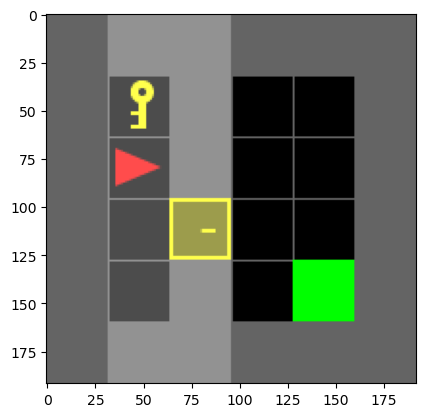

Start! use_bandit = False, double_train = False.


  5%|▍         | 451/10000 [06:32<2:18:23,  1.15it/s, episode=451, num_frames=108832, smooth_reward=0.94, reward=1, policy_loss=0.00625, value_loss=0.0102] 


Solved!
Start! use_bandit = True, double_train = False.


  3%|▎         | 321/10000 [04:05<2:03:13,  1.31it/s, smooth_reward=0.94, mean=-3.88, std=0.206, policy_loss=0.0207, num_frames=69486, episode=321, reward=1, value_loss=0.056]     

Solved!


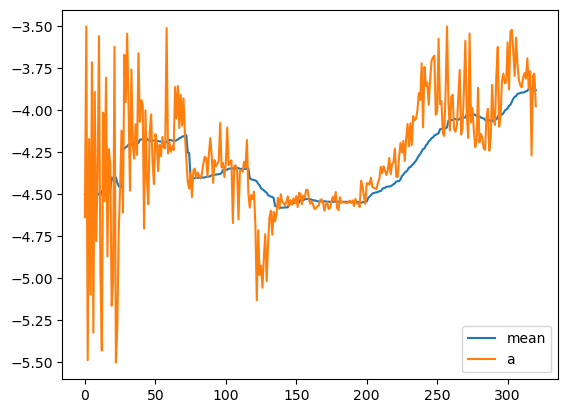

Start! use_bandit = False, double_train = True.


  0%|          | 31/10000 [00:38<3:26:44,  1.24s/it, episode=30, num_frames=9200, smooth_reward=0.02, reward=0, policy_loss=-0.00679, value_loss=0.00628]

poped


  1%|          | 66/10000 [01:25<2:58:01,  1.08s/it, episode=65, num_frames=18905, smooth_reward=0.12, reward=0, policy_loss=0.0271, value_loss=0.0974]   

poped


  1%|          | 113/10000 [02:12<1:43:34,  1.59it/s, episode=112, num_frames=28302, smooth_reward=0.52, reward=1, policy_loss=-0.186, value_loss=0.109]  

poped


  2%|▏         | 181/10000 [03:08<2:50:22,  1.04s/it, episode=181, num_frames=34875, smooth_reward=0.94, reward=1, policy_loss=-0.26, value_loss=0.233]   


Solved!
Start! use_bandit = True, double_train = True.


  3%|▎         | 281/10000 [05:02<2:54:35,  1.08s/it, smooth_reward=0.94, mean=-4.58, std=0.529, policy_loss=-0.0385, num_frames=54286, episode=281, reward=1, value_loss=0.0323] 

Solved!


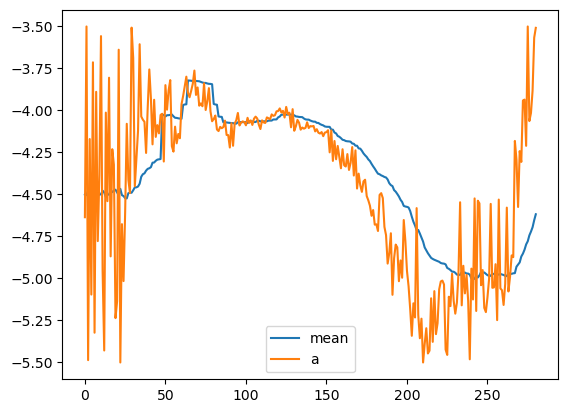

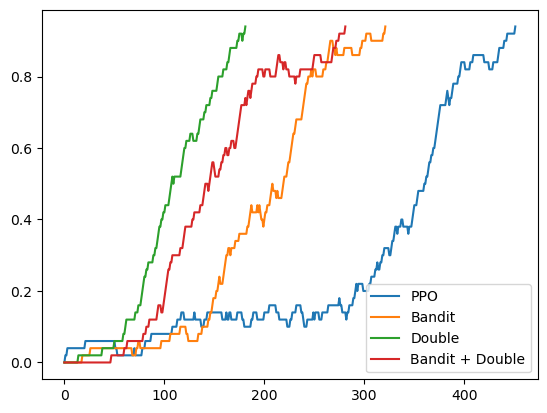

In [65]:
f1, f2 = whole_pipeline(6, 1510, args=Config(use_critic=True, use_gae=True))

In [60]:
f2

[1.0,
 1.0,
 0.9230769276618958,
 0.9926739931106567,
 0.8424908518791199,
 0.9157509207725525,
 0.9780219793319702,
 0.9632107019424438,
 0.8896321058273315,
 0.8628762364387512,
 0.8896321058273315,
 0.8795986771583557,
 0.7993311285972595,
 0.8494983315467834,
 0.8058608174324036,
 0.9966555237770081,
 0.984375,
 0.7959865927696228,
 0.8023256063461304,
 0.8896321058273315,
 0.8959537744522095,
 0.930232584476471,
 0.8125,
 0.84375,
 0.8734177350997925,
 0.8877550959587097,
 0.930232584476471,
 0.9653179049491882,
 0.8595317602157593,
 0.8160535097122192,
 0.8258928656578064,
 0.7830188870429993,
 0.7525083422660828,
 0.9871794581413269,
 0.8979591727256775,
 0.8561872839927673,
 0.82421875,
 0.9113923907279968,
 0.921875,
 0.9714285731315613,
 0.8857142925262451,
 0.9512194991111755,
 0.9166666865348816,
 0.8857142925262451,
 0.8481012582778931,
 0.9489796161651611,
 0.9163879752159119,
 0.7594936490058899,
 0.890625,
 0.95703125,
 0.9428571462631226,
 0.9466666579246521,
 0.951219